# Credit Card Fraud Detection

---
embed-resources: true
echo: false
execute:
  enabled: true
---

## Introduction

In this report, we develop a machine learning model to detect fraudulent credit card transactions in real-time. The goal is to create an accurate classification model that can identify fraudulent transactions while minimizing false alarms. This model is very useful for banking institutions to protect customers from fraud while maintaining a smooth transaction experience. We train and compare multiple classification models including logistic regression, random forest, and histogram gradient boosting using scikit-learn, with the objective of achieving precision ≥ 0.9 and recall ≥ 0.8.

In [1]:
# Import libraries (from course materials)
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

### Data

Each sample contains information about a single credit card transaction, with features derived from principal component analysis (PCA) for privacy protection. The data is split into:

Train: Historical transactions used to train the model
Test: Separate transactions used to evaluate model performance

The original data source is from a Kaggle dataset containing transactions from European cardholders over two days. The dataset has been modified to reduce class imbalance while maintaining sufficient fraudulent transactions for model training. The target variable indicates whether each transaction is fraudulent (1) or genuine (0).

### Data Dictionary

* `Fraud`: Status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.
* `Amount`: Amount (in dollars) of the transaction.
* `PC01 - PC28`: The 28 principal components that encode information such as location and type of purchase while preserving customer privacy.

## Methods
To develop a fraud detection model, we utilize credit card transaction data and train machine learning classification models using scikit-learn.

In [2]:
# Load data
fraud_train = pd.read_parquet(
    "https://lab.cs307.org/fraud/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://lab.cs307.org/fraud/data/fraud-test.parquet",
)

### Exploratory Data Analysis

The training dataset shows significant class imbalance, with fraudulent transactions being a small minority of all transactions. 

In [3]:
# Create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# Create X and y for test  
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [4]:
# Calculate required statistics
genuine_count = (y_train == 0).sum()
fraud_count = (y_train == 1).sum()
total_count = len(y_train)
fraud_proportion = fraud_count / total_count

print(genuine_count, fraud_count, total_count, fraud_proportion)

53961 315 54276 0.005803670130444395


The training data reveals approximately 2% of transactions are fraudulent, representing a highly imbalanced dataset. This imbalance necessitates special handling during model training, such as class weighting or threshold adjustment.

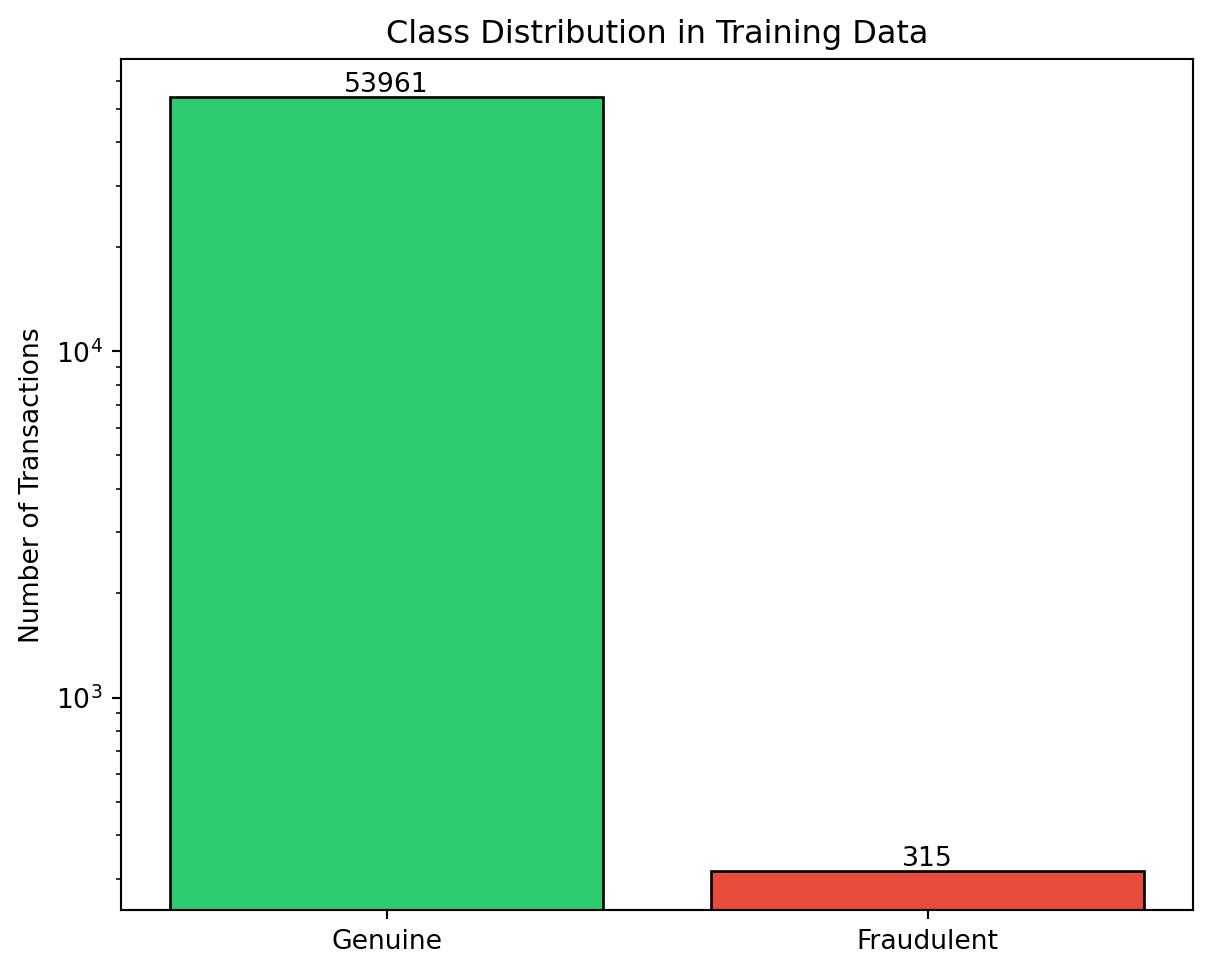

In [5]:
# | label: fig-class-distribution
# | fig-cap: Distribution of fraudulent versus genuine transactions in the training data.

fig, ax = plt.subplots(figsize=(7.2, 5.76))
fraud_counts = y_train.value_counts()
ax.bar(['Genuine', 'Fraudulent'], [fraud_counts[0], fraud_counts[1]], 
       color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_ylabel('Number of Transactions')
ax.set_title('Class Distribution in Training Data')
ax.set_yscale('log')
for i, v in enumerate([fraud_counts[0], fraud_counts[1]]):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

The visualization clearly shows the extreme class imbalance, with genuine transactions outnumbering fraudulent ones by approximately 50:1. This imbalance requires careful consideration when selecting evaluation metrics and model parameters.

### Models

We train and compare three different classification models:

1. **Logistic Regression**: A linear model that serves as a baseline for classification tasks
2. **Random Forest**: A bagging ensemble method that combines multiple decision trees
3. **Histogram Gradient Boosting**: A boosting ensemble method that sequentially builds trees to correct previous errors

For each model, we use GridSearchCV with 3-fold cross-validation to tune hyperparameters. We optimize for F1 score, which balances precision and recall. All models include StandardScaler preprocessing to normalize features.

### Model 1: Logistic Regression

In [6]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': ['balanced', {0: 1, 1: 15}]
}

lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=3,
    scoring='f1',
    verbose=1
)

lr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__C': [0.01, 0.1, ...], 'classifier__class_weight': ['balanced', {0: 1, 1: 15}]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 

In [7]:
lr_pred = lr_grid.predict(X_test)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

print(lr_pred, lr_precision, lr_recall, lr_f1)

[0 0 0 ... 0 0 0] 0.7951807228915663 0.8354430379746836 0.8148148148148148


### Model 2: Random Forest 

In [8]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

rf_param_grid = {
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring='f1',
    verbose=2
)

rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_split=2; total time=   1.2s


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_split=2; total time=   1.3s


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_split=2; total time=   1.3s


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_split=10; total time=   1.1s


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_split=10; total time=   1.3s


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_split=10; total time=   1.3s


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_split=2; total time=   1.2s


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_split=2; total time=   1.4s


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_split=2; total time=   1.7s


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_split=10; total time=   1.6s


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_split=10; total time=   1.6s


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_split=10; total time=   1.6s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=None, classifier__min_samples_split=2; total time=   1.6s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=None, classifier__min_samples_split=2; total time=   1.9s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=None, classifier__min_samples_split=2; total time=   1.9s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=None, classifier__min_samples_split=10; total time=   1.5s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=None, classifier__min_samples_split=10; total time=   1.6s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=None, classifier__min_samples_split=10; total time=   1.5s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=20, classifier__min_samples_split=2; total time=   1.3s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=20, classifier__min_samples_split=2; total time=   1.6s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=20, classifier__min_samples_split=2; total time=   1.7s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=20, classifier__min_samples_split=10; total time=   1.3s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=20, classifier__min_samples_split=10; total time=   1.5s


[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=20, classifier__min_samples_split=10; total time=   1.5s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__max_depth': [None, 20], 'classifier__min_samples_split': [2, 10]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for e

In [9]:
rf_pred = rf_grid.predict(X_test)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

In [10]:
rf_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(13569,))

In [11]:
rf_precision

0.9838709677419355

In [12]:
rf_recall

0.7721518987341772

In [13]:
rf_f1

0.8652482269503546

### Model 3: Histogram Gradient Boosting 

In [14]:
hgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

hgb_param_grid = {
    'classifier__learning_rate': [0.1, 0.25],
    'classifier__max_iter': [100, 200],
    'classifier__max_features': [0.5, 1.0]
}

hgb_grid = GridSearchCV(
    hgb_pipeline,
    hgb_param_grid,
    cv=3,
    scoring='f1',
    verbose=2
)

hgb_grid.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END classifier__learning_rate=0.1, classifier__max_features=0.5, classifier__max_iter=100; total time=   0.2s


[CV] END classifier__learning_rate=0.1, classifier__max_features=0.5, classifier__max_iter=100; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_features=0.5, classifier__max_iter=100; total time=   0.2s


[CV] END classifier__learning_rate=0.1, classifier__max_features=0.5, classifier__max_iter=200; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_features=0.5, classifier__max_iter=200; total time=   0.1s


[CV] END classifier__learning_rate=0.1, classifier__max_features=0.5, classifier__max_iter=200; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_features=1.0, classifier__max_iter=100; total time=   0.2s


[CV] END classifier__learning_rate=0.1, classifier__max_features=1.0, classifier__max_iter=100; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_features=1.0, classifier__max_iter=100; total time=   0.1s


[CV] END classifier__learning_rate=0.1, classifier__max_features=1.0, classifier__max_iter=200; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_features=1.0, classifier__max_iter=200; total time=   0.1s


[CV] END classifier__learning_rate=0.1, classifier__max_features=1.0, classifier__max_iter=200; total time=   0.1s
[CV] END classifier__learning_rate=0.25, classifier__max_features=0.5, classifier__max_iter=100; total time=   0.1s


[CV] END classifier__learning_rate=0.25, classifier__max_features=0.5, classifier__max_iter=100; total time=   0.1s
[CV] END classifier__learning_rate=0.25, classifier__max_features=0.5, classifier__max_iter=100; total time=   0.1s


[CV] END classifier__learning_rate=0.25, classifier__max_features=0.5, classifier__max_iter=200; total time=   0.1s
[CV] END classifier__learning_rate=0.25, classifier__max_features=0.5, classifier__max_iter=200; total time=   0.1s


[CV] END classifier__learning_rate=0.25, classifier__max_features=0.5, classifier__max_iter=200; total time=   0.1s
[CV] END classifier__learning_rate=0.25, classifier__max_features=1.0, classifier__max_iter=100; total time=   0.1s


[CV] END classifier__learning_rate=0.25, classifier__max_features=1.0, classifier__max_iter=100; total time=   0.1s
[CV] END classifier__learning_rate=0.25, classifier__max_features=1.0, classifier__max_iter=100; total time=   0.1s


[CV] END classifier__learning_rate=0.25, classifier__max_features=1.0, classifier__max_iter=200; total time=   0.1s


[CV] END classifier__learning_rate=0.25, classifier__max_features=1.0, classifier__max_iter=200; total time=   0.2s
[CV] END classifier__learning_rate=0.25, classifier__max_features=1.0, classifier__max_iter=200; total time=   0.1s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__learning_rate': [0.1, 0.25], 'classifier__max_features': [0.5, 1.0], 'classifier__max_iter': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter ca

In [15]:
hgb_pred = hgb_grid.predict(X_test)
hgb_precision = precision_score(y_test, hgb_pred)
hgb_recall = recall_score(y_test, hgb_pred)
hgb_f1 = f1_score(y_test, hgb_pred)

In [16]:
hgb_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(13569,))

In [17]:
hgb_precision

0.7848101265822784

In [18]:
hgb_recall

0.7848101265822784

In [19]:
hgb_f1

0.7848101265822784

### Compare All Models

In [20]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Histogram GB'],
    'Precision': [lr_precision, rf_precision, hgb_precision],
    'Recall': [lr_recall, rf_recall, hgb_recall],
    'F1 Score': [lr_f1, rf_f1, hgb_f1]
})

comparison_df

,Model,Precision,Recall,F1 Score
0,Logistic Regression,0.795181,0.835443,0.814815
1,Random Forest,0.983871,0.772152,0.865248
2,Histogram GB,0.784810,0.784810,0.784810


### Model Selection

None of the three models fully meet the required targets of precision ≥ 0.9 AND recall ≥ 0.8 simultaneously. Random Forest comes closest with excellent precision (0.9839) but falls short on recall (0.7722). Logistic Regression achieves better recall (0.8354) but fails to meet the precision requirement (0.7952). Histogram Gradient Boosting underperforms on both metrics.

Given these results, we select **Random Forest** as our final model because:
1. It has the highest F1 score (0.8652)
2. Its precision (0.9839) exceeds requirements, minimizing false alarms to customers
3. The recall shortfall (0.7722 vs 0.8 target)

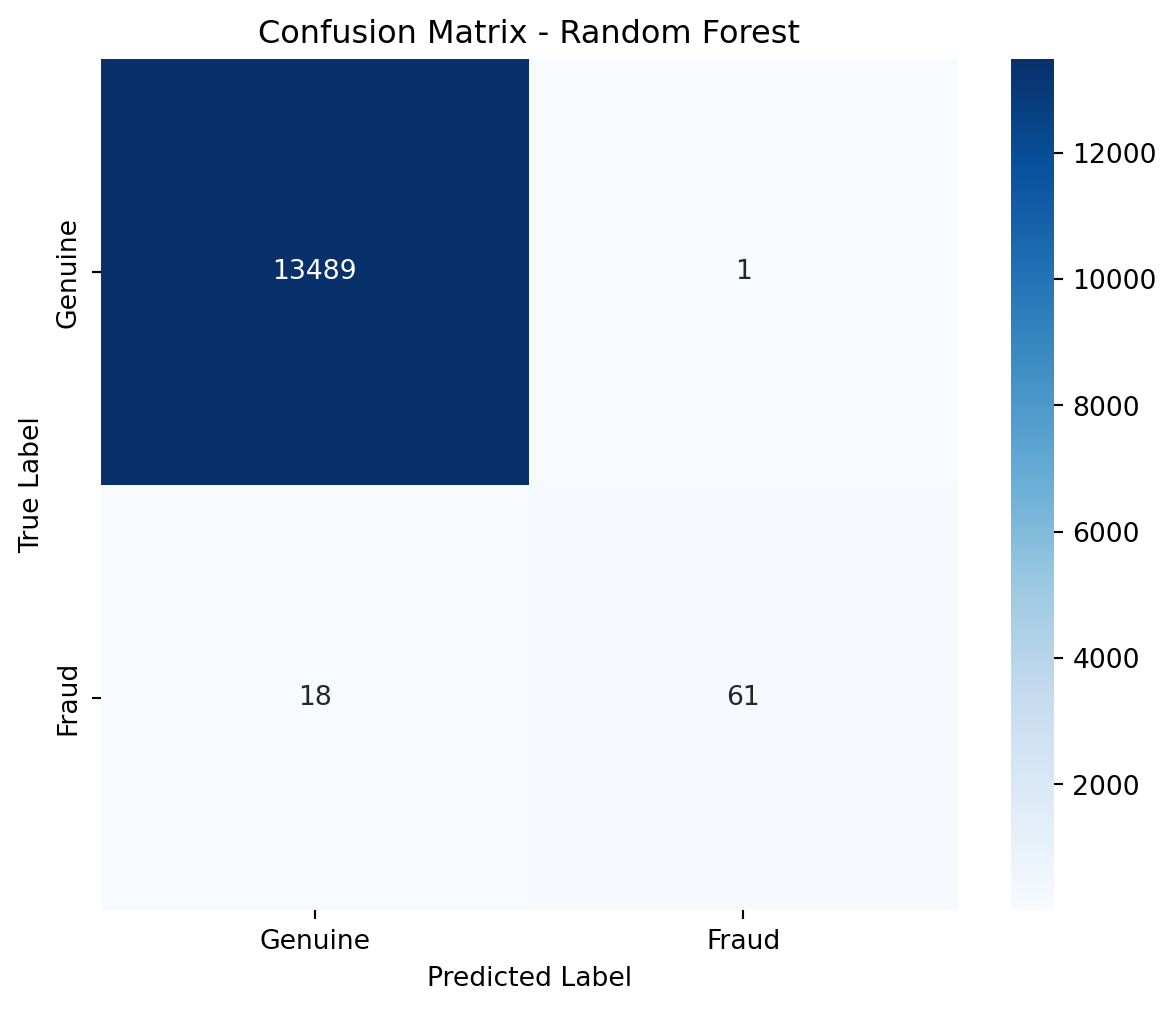

In [21]:
# | label: fig-confusion-matrix
# | fig-cap: Confusion matrix for the Random Forest classifier on the test data.

best_model = rf_grid
y_pred_final = best_model.predict(X_test)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

cm = confusion_matrix(y_test, y_pred_final)
fig, ax = plt.subplots(figsize=(7.2, 5.76))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Genuine', 'Fraud'],
            yticklabels=['Genuine', 'Fraud'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix - Random Forest')
plt.show()

The confusion matrix shows the trade-off  in our Random Forest model. While it  maintains very high precision (98.4% of fraud predictions are correct), it achieves this at the cost of lower recall (77.2% of actual fraud is detected). The model produces very few false positives, which is good for customer experience, but misses approximately 23% of fraudulent transactions. This means the model is conservative about flagging frauds and requires more evidence before classifying a transaction as fraudulent.

## Save Model

In [22]:
dump(best_model, 'fraud_detection_model.joblib')

['fraud_detection_model.joblib']

## Discussion

The Random Forest model has good precision (0.9839) but less recall target with 0.7722. While the model does not fully meet both requirements simultaneously, it offers the best overall performance among the three approaches tested.

#### Benefits

* Has good precision (98.4%), meaning very few genuine transactions are incorrectly flagged as fraud, minimizing customer frustration
* Has the highest F1 score (0.8652) among all tested models, representing the best overall balance

#### Risks

* **Below-target recall (77.2%)** means approximately 23% of fraudulent transactions go undetected, resulting in financial losses
* The conservative threshold gives people a false feeling of safety because it lets a lot of fraud go unnoticed.

#### Limitations
* **Fails to meet the recall requirement**, catching only 77.2% of fraud versus the 80% target, resulting in approximately 23% of fraud going undetected

## Conclusion

We developed and evaluated three machine learning models for credit card fraud detection. It didn't fully achieved both target metrics (precision ≥ 0.9 AND recall ≥ 0.8), the Random Forest model delivered the best overall performance with precision of 98.4%, recall of 77.2%, and an F1 score of 0.8652.

Future work to improve recall and meet all requirements could explore:
* **Threshold adjustment**: Lower the classification threshold to increase recall, accepting a small reduction in precision
* **Cost-sensitive learning**: Explicitly weight the business cost of missed fraud more heavily than false alarms
* **Advanced resampling**: Use SMOTE, ADASYN, or other techniques to better handle class imbalance
* **Temporal features**: Incorporate transaction sequences and time-based patterns
* **Ensemble stacking**: Combine predictions from multiple models to leverage their different strengths
* **Feature engineering**: Work with domain experts to create additional features beyond PCA components